<a href="https://colab.research.google.com/github/ShakthivelNadar/Credit-Card-Fraud-Detection/blob/main/CreditCardFraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imbalanced-learn xgboost

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report)
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv("/content/drive/MyDrive/creditcard.csv")
print(df.head())
print(df.info())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

Class
0    284315
1       492
Name: count, dtype: int64


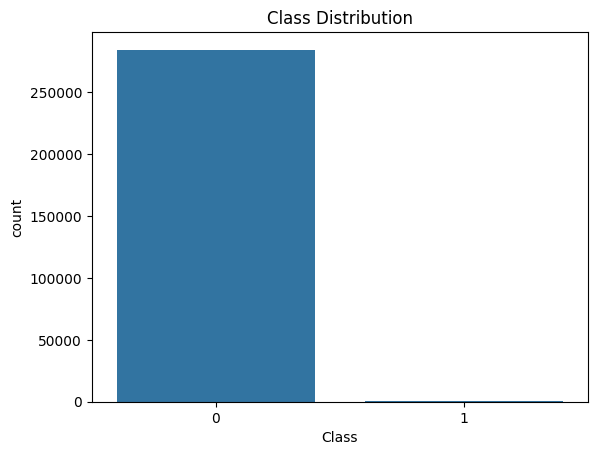

In [4]:
# Class distribution
print(df['Class'].value_counts())

sns.countplot(x='Class', data=df)
plt.title("Class Distribution")
plt.show()

In [5]:
scaler = StandardScaler()
df[['Amount', 'Time']] = scaler.fit_transform(df[['Amount', 'Time']])

In [6]:
X = df.drop('Class', axis=1)
y = df['Class']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

In [8]:
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(
    X_train, y_train)

print("After SMOTE:")
print(pd.Series(y_train_smote).value_counts())

After SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


In [9]:
lr = LogisticRegression(
    max_iter=1000,
    n_jobs=-1)

lr.fit(X_train_smote, y_train_smote)

y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

In [10]:
print("Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))
print(confusion_matrix(y_test, y_pred_lr))

Logistic Regression Results
Accuracy: 0.9742635441171307
F1 Score: 0.10935601458080195
ROC-AUC: 0.9698482164390798
[[55406  1458]
 [    8    90]]


In [11]:
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [12]:
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

In [13]:
print("XGBoost Results")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))

XGBoost Results
Accuracy: 0.9983848881710614
F1 Score: 0.6515151515151515
ROC-AUC: 0.9801215646641324


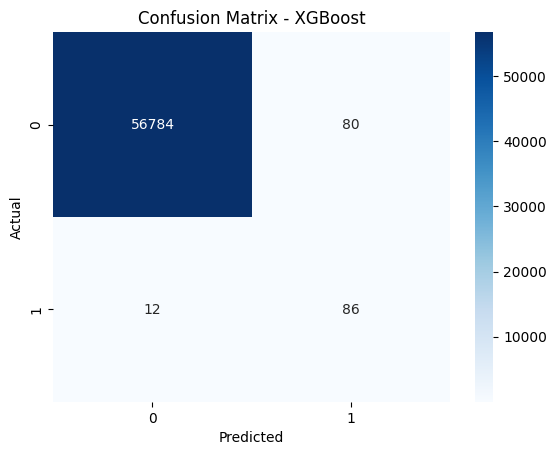

In [14]:
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [15]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.52      0.88      0.65        98

    accuracy                           1.00     56962
   macro avg       0.76      0.94      0.83     56962
weighted avg       1.00      1.00      1.00     56962



In [16]:
def real_time_fraud_detection(transaction):
    transaction = np.array(transaction).reshape(1, -1)
    prediction = xgb_model.predict(transaction)[0]
    probability = xgb_model.predict_proba(transaction)[0][1]

    if prediction == 1:
        return f" Fraud Detected (Risk Score: {probability:.2f})"
    else:
        return f" Legitimate Transaction (Risk Score: {probability:.2f})"

In [17]:
sample_transaction = X_test.iloc[5].values
print(real_time_fraud_detection(sample_transaction))

 Legitimate Transaction (Risk Score: 0.00)
